# Practice 2. PoseNet with KingsCollege Dataset & Apperance Change

**1. Import required library**

 필요한 라이브러리를 호출합니다.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from posenet import GoogLeNet as PoseNet
from utils import *
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))


**2. Set project directory & dataset path**

 현재 작업 폴더 및 데이터셋에 대한 경로를 설정합니다.

In [2]:
# Set this path to your project directory
path = './'
# Set this path to your dataset directory
directory = './SK_VisualLocalization_Test_Dataset/KingsCollege/'
dataset = 'dataset_seq2_test.txt'

**3. Load test images**

 작업에 필요한 이미지들을 읽어오고, 해당 이미지들을 네트워크에 넣어주기 전 필요한 Pre-processing을 수행합니다.
 PoseNet에 사용되는 네트워크는 GoogLeNet에 기반을 두고, GoogLeNet의 input의 경우, 224x224x3으로 고정되어 있기에,
 이미지에 적용되는 Pre-processing은 이미지를 resize하고, 224x224로 center crop을 수행합니다. 

In [3]:
image = tf.placeholder(tf.float32, [1, 224, 224, 3])
datasource = get_data(directory,dataset)
results = np.zeros((len(datasource.images),2))

100%|██████████| 5/5 [00:00<00:00, 3011.85it/s]


**4. Construct network**

 PoseNet 네트워크에 대한 초기화 및 받아오고자 하는 출력 값을 설정하여 줍니다.

In [4]:
net = PoseNet({'data': image})
p3_x = net.layers['cls3_fc_pose_xyz']
p3_q = net.layers['cls3_fc_pose_wpqr']

In [5]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

**5. Run the network & Evaluate the resutls**

 생성된 PoseNet의 weight로서 pre-trained 된 weight를 읽어옵니다.
 그 후, 데이터 셋에서 이미지를 하나씩 feed forward 시키고, 예측된 쿼터니언과 translation 결과를 출력합니다.
 GT 값과 예측된 결과 값들의 차이를 계산하고, 평가합니다.

INFO:tensorflow:Restoring parameters from ./PoseNet.ckpt
seq2/frame00031.png  Predicted_XYZ (m):  [ 26.07 -22.50 1.73  Predicted_Euler_XYZ (degrees):  [ 84.68 27.17 -3.80 ]
Iteration:   0   Error XYZ (m):   5.585301034460083   Error Q (degrees):   4.000048567173354
seq2/frame00032.png  Predicted_XYZ (m):  [ 26.46 -23.56 1.74  Predicted_Euler_XYZ (degrees):  [ 84.72 25.81 -2.06 ]
Iteration:   1   Error XYZ (m):   4.3401696644446845   Error Q (degrees):   4.306350308433945
seq2/frame00033.png  Predicted_XYZ (m):  [ 19.89 -19.62 2.32  Predicted_Euler_XYZ (degrees):  [ 73.80 3.68 0.48 ]
Iteration:   2   Error XYZ (m):   10.216268608992722   Error Q (degrees):   26.214344182698746
seq2/frame00034.png  Predicted_XYZ (m):  [ 9.87 -15.29 2.08  Predicted_Euler_XYZ (degrees):  [ 73.76 -16.19 -1.56 ]
Iteration:   3   Error XYZ (m):   19.709852822317128   Error Q (degrees):   46.50485176960643
seq2/frame00035.png  Predicted_XYZ (m):  [ 24.30 -22.44 1.77  Predicted_Euler_XYZ (degrees):  [ 86.88 23.

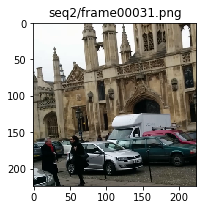

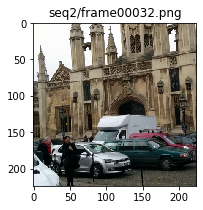

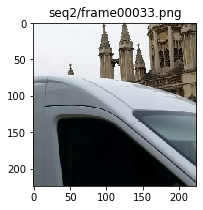

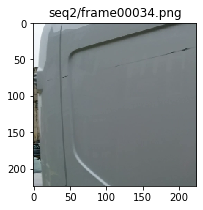

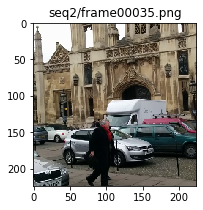

In [6]:
with tf.Session() as sess:
	# Load the data
	sess.run(init)
	saver.restore(sess, path + 'PoseNet.ckpt')
	data_gen = gen_data_batch(datasource)
	for i in range(len(datasource.images)):
		np_image = datasource.images[i]
		feed = {image: np_image}
        
		pose_q= np.asarray(datasource.poses[i][3:7])
		pose_x= np.asarray(datasource.poses[i][0:3])

		predicted_x, predicted_q = sess.run([p3_x, p3_q], feed_dict=feed)
		predicted_q = np.squeeze(predicted_q)
		predicted_x = np.squeeze(predicted_x)

        # convert quaternion to euler / display image and prediction results
		predicted_euler = quaternion_to_euler(predicted_q[1],predicted_q[2],predicted_q[3],predicted_q[0])
		plt.figure(figsize=(3,3))
		plt.title(datasource.names[i])
		plt.imshow(np.squeeze(datasource.images_cropped[i]))
		print (datasource.names[i], ' Predicted_XYZ (m): ','[', format(predicted_x[0],".2f") , format(predicted_x[1],".2f") , format(predicted_x[2],".2f"), ' Predicted_Euler_XYZ (degrees): ','[', format(predicted_euler[0],".2f") , format(predicted_euler[1],".2f") , format(predicted_euler[2],".2f"), ']')

		#Compute Individual Sample Error between GT and Prediction
		q1 = pose_q / np.linalg.norm(pose_q)
		q2 = predicted_q / np.linalg.norm(predicted_q)
		d = abs(np.sum(np.multiply(q1,q2)))
		theta = 2 * np.arccos(d) * 180/math.pi
		error_x = np.linalg.norm(pose_x-predicted_x)
		results[i,:] = [error_x,theta]
		print ('Iteration:  ', i, '  Error XYZ (m):  ', error_x, '  Error Q (degrees):  ', theta)

    #Compute Total Error
	median_result = np.median(results,axis=0)
	print ('Median error ', median_result[0], 'm  and ', median_result[1], 'degrees.')
 